In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import numpy as np
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [2]:
d = pd.read_csv('data/driving_log.csv')

In [3]:
d.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [5]:
a = d.iloc[0].center

In [9]:
b = d.iloc[0].left.strip()

In [14]:
c = d.iloc[0].right.strip()

In [15]:
a

'IMG/center_2016_12_01_13_30_48_287.jpg'

In [16]:
b

'IMG/left_2016_12_01_13_30_48_287.jpg'

In [17]:
c

'IMG/right_2016_12_01_13_30_48_287.jpg'

In [21]:
a_image = mpimg.imread('data/'+a)
b_image = mpimg.imread('data/'+b)
c_image = mpimg.imread('data/'+c)

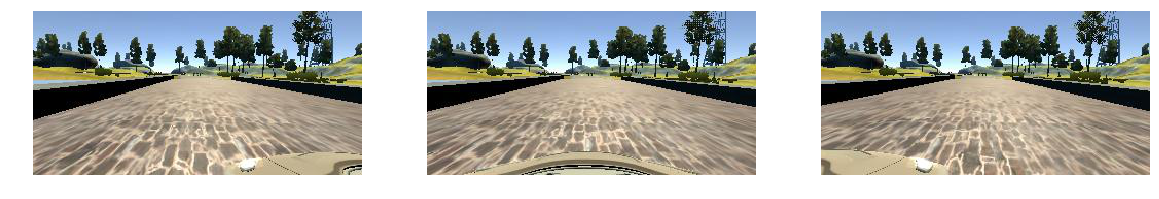

In [31]:
plt.figure(figsize=(20,14))
plt.subplot(131)
plt.imshow(b_image)

plt.axis('off')

plt.subplot(132)
plt.imshow(a_image)
plt.axis('off')

plt.subplot(133)
plt.imshow(c_image)
plt.axis('off')

plt.show()

In [37]:
d['steering'].value_counts()

 0.000000    4361
 0.176582     237
-0.145206     179
 0.090465     165
-0.059757     152
-0.078746     150
 0.167014     136
-0.069252     129
 0.042623     106
 0.128740      98
 0.052191      92
 0.071328      92
-0.088240      80
-0.002791      79
 0.013917      74
 0.061760      71
 0.157445      69
 0.100034      66
-0.050263      61
-0.211667      56
-0.116723      55
 0.023486      53
-0.135712      51
-0.154701      49
-0.021780      49
-0.040768      46
-0.297116      43
-0.221161      41
-0.287622      38
-0.031274      38
             ... 
 0.482775       3
 0.588029       3
 0.578461       3
 0.387090       3
 0.339247       2
 1.000000       2
-0.686385       2
 0.415796       2
 0.329679       2
-0.942695       2
 0.645440       2
-0.524981       2
-0.629419       2
-0.600936       2
-0.468015       2
 0.655009       1
 0.731557       1
-0.430037       1
-0.923744       1
 0.425364       1
-0.458520       1
 0.626303       1
-0.933238       1
-0.771834       1
-0.477509 

In [ ]:
# input 320x160, steering angle
# NV paper, input 200x66, YUV
# 200x100
# 320x88

model = Sequential()
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2), input_shape=(66, 200, 3)))
# model.add(MaxPooling2D(border_mode='same'))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
# model.add(MaxPooling2D(border_mode='same'))
model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
# model.add(MaxPooling2D(border_mode='same'))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu'))
model.add(Flatten())
# model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile('adam', 'mse')
# model.summary()

In [ ]:
driving_log = pd.read_csv('data/driving_log.csv')
num_of_sample = len(driving_log)


In [ ]:
def preprocessing(img):
    # crop 160x320 ==> 99x300
    img_tmp = img[41:139, 10:310, :]
    # resize 99x300 ==> 66x200
    img_tmp = cv2.resize(img_tmp, (200, 66))
    # BGR2YUV
    img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2YUV)
    # normalize
    img_tmp = img_tmp.astype(np.float32)
    img_tmp = (img_tmp - 128) / 128
    
    return img_tmp

In [ ]:
def generate_arrays_from_file(batch_size=32):
    while True:
        X = []
        y = []

        for i in range(batch_size):
            # select idx
            idx = np.random.randint(0, num_of_sample)
            # select camera, 0 center, 1 left, 2 right
            camera = np.random.randint(0, 3)

            filename = driving_log.iloc[idx][camera].strip()
            steering = driving_log.iloc[idx]['steering']
            if camera == 1:
                steering -= 0.25
            elif camera == 2:
                steering += 0.25
            img = cv2.imread('data/' + filename)
            img = preprocessing(img)
            # select mirror
            if np.random.randint(0, 2) % 2 == 1:
                img = img[:, ::-1, :]
                steering *= -1

            X.append(img)
            y.append(steering)
        assert len(X) == batch_size
        yield np.array(X), np.array(y)

In [ ]:
history = model.fit_generator(generate_arrays_from_file(), 20000, 8)
# model.fit_generator(generate_arrays_from_file('/my_file.txt'),
#         samples_per_epoch=10000, nb_epoch=10)

In [ ]:
json_string = model.to_json()
json.dump(json_string, 'model.json')
model.save_weights('model.h5')

In [ ]:
c2 = preprocessing(cv2.imread('data/IMG/' + CENTER))